## Initial Setup

In [1]:
!git clone https://github.com/syncdoth/Eagle-Eye-Pneumonia-Detection.git

Cloning into 'Eagle-Eye-Pneumonia-Detection'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 219 (delta 22), reused 31 (delta 15), pack-reused 175
Receiving objects: 100% (219/219), 146.87 KiB | 18.36 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [2]:
!bash Eagle-Eye-Pneumonia-Detection/utils/connect_in_colab.sh

The following NEW packages will be installed:
  sshpass
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 10.5 kB of archives.
After this operation, 30.7 kB of additional disk space will be used.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package sshpass.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../sshpass_1.06-1_amd64.deb ...
Unpacking sshpass (1.06-1) ...
Setting up sshpass (1.06-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
┌━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
%cd Eagle-Eye-Pneumonia-Detection

/content/Eagle-Eye-Pneumonia-Detection


In [4]:
!pip install --upgrade pip
!pip install -r colab_requirements.txt

     |████████████████████████████████| 1.5MB 28.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 1.9 MB 65.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16033 sha256=d294b5d45138e7b3a073c7b943516601409449eadf929cde5d6cd8c53ecea75a
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## Train

In [1]:
import torch
from importlib import reload
from torch.utils.data import SubsetRandomSampler
from models.type_classifier import TypeClassifier
import models.train
reload(models.train)
from models.train import train, make_batch
import dataloader.ClassificationDataset
reload(dataloader.ClassificationDataset)
from dataloader.ClassificationDataset import ClassificationDataset, AddGaussianNoise
import torchvision
from torchvision import transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
feature_aug = torchvision.transforms.Compose([
                transforms.ToTensor(),
                transforms.ColorJitter(brightness=[0.1,0.5], contrast=0, saturation=0, hue=0),
                transforms.RandomAffine(degrees=(0,15),
                                        translate=None,
                                        scale=None,
                                        shear=None,
                                        fillcolor=None,
                                        resample=None),
                AddGaussianNoise(0., 1.)])

In [3]:
dataset = ClassificationDataset(root="/home/server/duhyeuk", neg_prop=0.5)

In [6]:
dataset = ClassificationDataset(root="/content/data_server", neg_prop=0.5, trans=feature_aug)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.train_idx))
val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.val_idx))
test_loader = torch.utils.data.DataLoader(dataset, batch_size=32, collate_fn=make_batch, sampler=SubsetRandomSampler(dataset.test_idx))

In [7]:
version = "b1"
pretrain_model = TypeClassifier(version=version, num_classes=4).to(device)

optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=1e-5)
loss = torch.nn.CrossEntropyLoss(weight=torch.FloatTensor(dataset.get_class_weights()).to(device))
epochs = 10

history = train(pretrain_model, optimizer, train_loader, device, loss, 
                val_dataset=val_loader, epochs=epochs,
                model_dir=f"/content/drive/MyDrive/eagle_eye_models/{version}")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0



[train] epoch: 0, loss: 0.03981382127988505, accracy: 0.5653866113129217
[valid] epoch: 0, loss: 1.1713455729186535, report:
{'0': {'precision': 0.7572815533980582, 'recall': 0.4875, 'f1-score': 0.5931558935361217, 'support': 160}, '1': {'precision': 1.0, 'recall': 0.15476190476190477, 'f1-score': 0.2680412371134021, 'support': 168}, '2': {'precision': 0.0703125, 'recall': 0.6, 'f1-score': 0.12587412587412586, 'support': 15}, '3': {'precision': 0.5911111111111111, 'recall': 0.9568345323741008, 'f1-score': 0.7307692307692308, 'support': 139}, 'accuracy': 0.5103734439834025, 'macro avg': {'precision': 0.6046762911272924, 'recall': 0.5497741092840014, 'f1-score': 0.42946012182322013, 'support': 482}, 'weighted avg': {'precision': 0.7725812873197796, 'recall': 0.5103734439834025, 'f1-score': 0.5049811322943278, 'support': 482}}



[train] epoch: 1, loss: 0.03307449697025341, accracy: 0.7511676180591593
[valid] epoch: 1, loss: 1.0217498950660229, report:
{'0': {'precision': 0.7816091954022989, 'recall': 0.85, 'f1-score': 0.8143712574850299, 'support': 160}, '1': {'precision': 0.967741935483871, 'recall': 0.35714285714285715, 'f1-score': 0.5217391304347826, 'support': 168}, '2': {'precision': 0.12195121951219512, 'recall': 0.6666666666666666, 'f1-score': 0.2061855670103093, 'support': 15}, '3': {'precision': 0.8170731707317073, 'recall': 0.9640287769784173, 'f1-score': 0.8844884488448844, 'support': 139}, 'accuracy': 0.7053941908713693, 'macro avg': {'precision': 0.672093880282518, 'recall': 0.7094595751969852, 'f1-score': 0.6066961009437515, 'support': 482}, 'weighted avg': {'precision': 0.8361837250001004, 'recall': 0.7053941908713693, 'f1-score': 0.7136685746996719, 'support': 482}}



[train] epoch: 2, loss: 0.027593900595047835, accracy: 0.809548521017125
[valid] epoch: 2, loss: 0.8189889416098595, report:
{'0': {'precision': 0.8351648351648352, 'recall': 0.95, 'f1-score': 0.888888888888889, 'support': 160}, '1': {'precision': 0.9775280898876404, 'recall': 0.5178571428571429, 'f1-score': 0.6770428015564203, 'support': 168}, '2': {'precision': 0.1694915254237288, 'recall': 0.6666666666666666, 'f1-score': 0.27027027027027023, 'support': 15}, '3': {'precision': 0.881578947368421, 'recall': 0.9640287769784173, 'f1-score': 0.9209621993127147, 'support': 139}, 'accuracy': 0.7946058091286307, 'macro avg': {'precision': 0.7159408494611563, 'recall': 0.7746381466255567, 'f1-score': 0.6892910400070735, 'support': 482}, 'weighted avg': {'precision': 0.8774542308984723, 'recall': 0.7946058091286307, 'f1-score': 0.8050481590087598, 'support': 482}}



[train] epoch: 3, loss: 0.02365151760673424, accracy: 0.8425012973533991
[valid] epoch: 3, loss: 0.6674616979435086, report:
{'0': {'precision': 0.8333333333333334, 'recall': 0.96875, 'f1-score': 0.8959537572254336, 'support': 160}, '1': {'precision': 0.9818181818181818, 'recall': 0.6428571428571429, 'f1-score': 0.776978417266187, 'support': 168}, '2': {'precision': 0.20454545454545456, 'recall': 0.6, 'f1-score': 0.30508474576271183, 'support': 15}, '3': {'precision': 0.9366197183098591, 'recall': 0.9568345323741008, 'f1-score': 0.9466192170818505, 'support': 139}, 'accuracy': 0.8402489626556017, 'macro avg': {'precision': 0.7390791720017071, 'recall': 0.792110418807811, 'f1-score': 0.7311590343340457, 'support': 482}, 'weighted avg': {'precision': 0.8953052085934441, 'recall': 0.8402489626556017, 'f1-score': 0.8507081278373583, 'support': 482}}



[train] epoch: 4, loss: 0.02078082765484945, accracy: 0.8624805396990141
[valid] epoch: 4, loss: 0.6068506594747305, report:
{'0': {'precision': 0.8516483516483516, 'recall': 0.96875, 'f1-score': 0.9064327485380117, 'support': 160}, '1': {'precision': 0.9834710743801653, 'recall': 0.7083333333333334, 'f1-score': 0.8235294117647058, 'support': 168}, '2': {'precision': 0.23076923076923078, 'recall': 0.6, 'f1-score': 0.33333333333333337, 'support': 15}, '3': {'precision': 0.95, 'recall': 0.9568345323741008, 'f1-score': 0.953405017921147, 'support': 139}, 'accuracy': 0.8630705394190872, 'macro avg': {'precision': 0.753972164199437, 'recall': 0.8084794664268586, 'f1-score': 0.7541751278892994, 'support': 482}, 'weighted avg': {'precision': 0.9066357162264366, 'recall': 0.8630705394190872, 'f1-score': 0.8732478805676179, 'support': 482}}


## Visualize Results

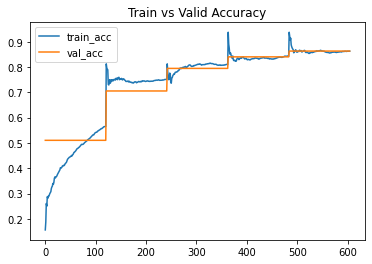

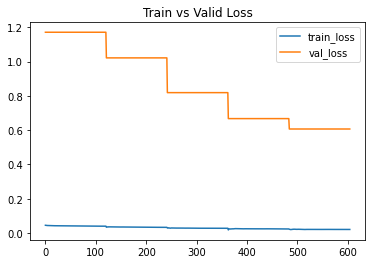

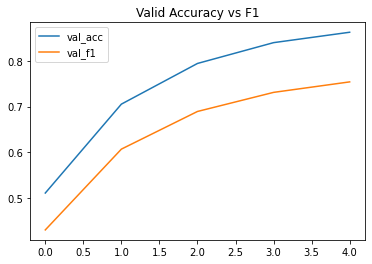

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.title("Train vs Valid Accuracy")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(np.repeat(np.array(history["val_acc"]), len(train_loader)), label="val_acc")
plt.legend()

plt.figure()
plt.title("Train vs Valid Loss")
plt.plot(history["train_loss"], label="train_loss")
plt.plot(np.repeat(np.array(history["val_loss"]), len(train_loader)), label="val_loss")
plt.legend()

plt.figure()
plt.title("Valid Accuracy vs F1")
plt.plot(np.array(history["val_acc"]), label="val_acc")
plt.plot(np.array(history["val_f1"]), label="val_f1")
plt.legend();
